# Community detection code profiling

Notebook generates synthetic datasets of different configurations (different number of layers and elements per layer) and explores the performance of code (execution time and memory consumption) for each of selected configurations. Initial version relies on MolTi implementation for the communities detection problem, but pipeline can be adapted to benchmarking of different [communities detection algorithms](https://link.springer.com/article/10.1007/s10618-020-00716-6) like [InfoMap](https://github.com/mapequation/infomap).

## 0. Import dependencies

In [ ]:
# add parent directory to path so we can import utils
import sys
import os
import shutil
sys.path.append('../')
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pathlib import Path
import numpy as np
from BioMultiNet.utils import *
from BioMultiNet.cmmd import *
import networkx as nx
from tqdm.notebook import tqdm

In [ ]:
path_to_benchmark = Path("../data/benchmark/")
path_to_benchmark.mkdir(exist_ok=True)

## 1. Generate synthetic datasets

### 1.1 Scenario 1

Increase number of layers, all layers have the same number of nodes in them (`200`).

In [ ]:
n_layers = np.arange(1, 101, 1)
n = 200
p = 0.2

In [ ]:
path_to = path_to_benchmark / "scenario-1"
path_to.mkdir(exist_ok=True)

In [ ]:
obfuscate = True
label_edges = ""

for n_layer in tqdm(n_layers):
    # create directory for the dataset with current number of layers
    path_to = path_to_benchmark / f"scenario-1/{n_layer}"
    path_to.mkdir(exist_ok=True)

    # populate created directory with synthetic layers
    node_labels_pool = []
    for n_layer_idx in range(n_layer):
        G = create_and_save_random_graph(generator=nx.erdos_renyi_graph,
                                        label_edges=label_edges,
                                        path_to=path_to / f"{n_layer_idx}.csv",
                                        n=n,
                                        p=p,
                                        directed=False,
                                        obfuscate=obfuscate,
                                        node_labels_pool=node_labels_pool)
        node_labels_pool.extend(list(G.nodes()))
    

  0%|          | 0/100 [00:00<?, ?it/s]

## 2. Benchmarking

For the selected scenario let's compute community detection problem, log consumed resources and viaualize them.

In [ ]:
d = {}

prefix_ = path_to_benchmark / "scenario-1"

for k in tqdm(os.listdir(prefix_)):
    # select the folder with the mentioned number of layers
    prefix = str(prefix_) + "/" + k
    # list of the filenames - input layers
    input_layers = [prefix + "/" + x for x in os.listdir(prefix) if x.endswith(".csv")]

    for l in input_layers:
        assert Path(l).exists()

    start = time.time()
    cmmd_output = cmmd(nodelist = None,
        input_layers = input_layers,
        gamma_min = 0,
        gamma_max = 30,
        gamma_step = 0.5,
        path_to_communities = "../out/communities/",
        distmethod = "hamming",
        n_jobs = 6)
    
    duration = time.time() - start

    # clean up
    shutil.rmtree("../out/communities/")

    d[k] = duration

print(d)

  0%|          | 0/100 [00:00<?, ?it/s]

{'31': 6.770324945449829, '75': 14.484583854675293, '42': 8.959571838378906, '15': 3.7124531269073486, '71': 13.9744873046875, '3': 1.1011457443237305, '78': 15.205758571624756, '24': 5.371524095535278, '84': 16.141170501708984, '100': 19.349994897842407, '72': 14.28057074546814, '85': 16.635345220565796, '59': 11.813063621520996, '12': 3.14388370513916, '88': 17.228288412094116, '90': 17.65051031112671, '66': 13.965642213821411, '8': 2.285508394241333, '17': 4.0732581615448, '4': 1.3713326454162598, '38': 8.058760643005371, '20': 4.781110763549805, '93': 18.834080934524536, '18': 4.254984140396118, '21': 4.830830335617065, '5': 1.65264892578125, '70': 13.980457305908203, '65': 12.718465566635132, '73': 14.824580669403076, '22': 5.000579357147217, '9': 2.51029634475708, '6': 1.818345546722412, '53': 11.076967477798462, '2': 0.8684158325195312, '91': 17.708168745040894, '98': 18.87727403640747, '55': 11.234635591506958, '50': 10.009679794311523, '49': 10.039834260940552, '94': 18.309519

In [ ]:
# sort the dictionary
sorted_d = dict(sorted(d.items(), key=lambda item: item[1]))

In [ ]:
# create a dataframe from the dictionary
df = pd.DataFrame.from_dict(sorted_d, orient='index')
df = df.reset_index()
df = df.rename(columns={'index': 'n_layers', 0: 'duration'})
df.head()

,n_layers,duration
0,1,0.502748
1,2,0.868416
2,3,1.101146
3,4,1.371333
4,5,1.652649


In [ ]:
# save the dataframe to csv
df.to_csv("../out/duration.csv", index=False)

In [ ]:
width = 15
height = 8
matplotlib.rcParams['figure.figsize'] = [width, height]

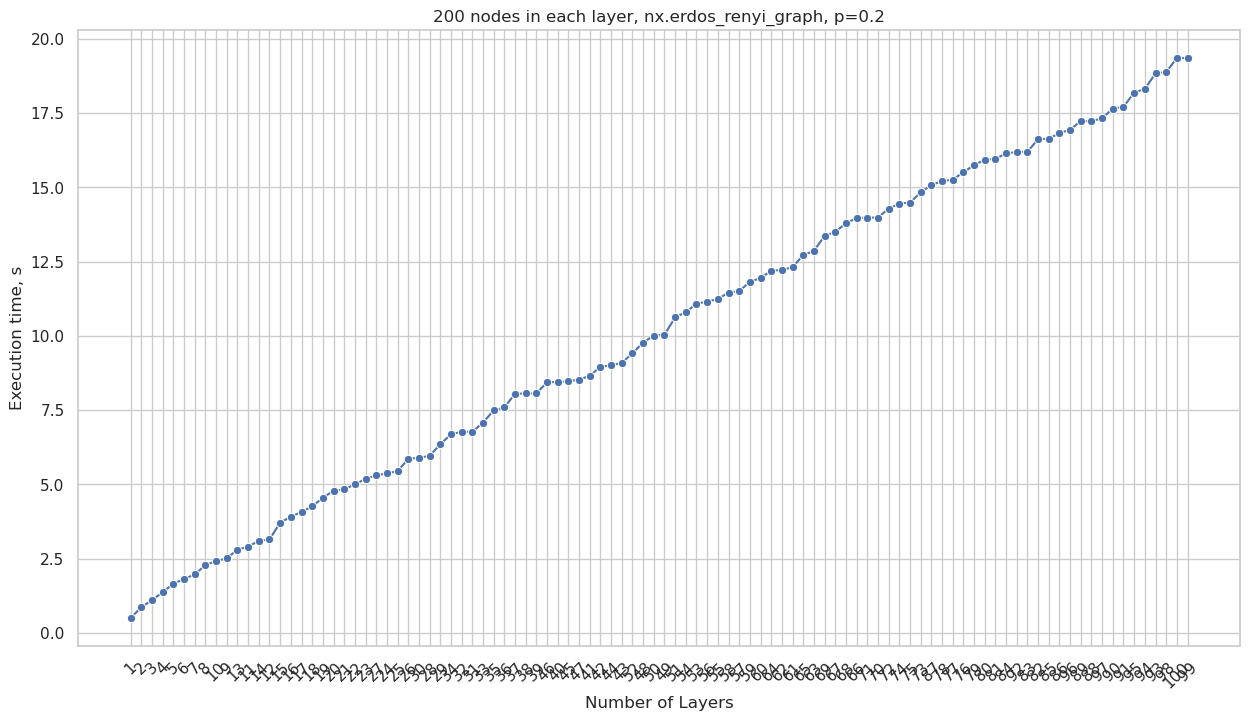

In [ ]:
# Create the plot (using a line plot as an example)
sns.lineplot(x='n_layers', y='duration', data=df, marker='o')

# Rotate the x-axis labels for a compact look
plt.xticks(rotation=45)  # Rotate by 45 degrees

# Add labels and title
plt.xlabel('Number of Layers')
plt.ylabel('Execution time, s')
plt.title('200 nodes in each layer, nx.erdos_renyi_graph, p=0.2')

# Display the plot
plt.show()